In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

In [6]:
feature_engineered_df = pd.read_csv('../data/feature-engineered/recession_probability.csv')

In [57]:
dtypes_dict = feature_engineered_df.dtypes.apply(lambda x: x.name).to_dict()
for col, dtype in dtypes_dict.items():
    print(f"{col}: {dtype}")


date: object
recession_probability: float64
1_month_recession_probability: float64
3_month_recession_probability: float64
6_month_recession_probability: float64
1_year_rate: float64
3_months_rate: float64
6_months_rate: float64
CPI: float64
INDPRO: float64
10_year_rate: float64
share_price: float64
unemployment_rate: float64
PPI: float64
OECD_CLI_index: float64
CSI_index: float64
Year: int64
Quarter_Number: int64
Month_Number: int64
gdp_per_capita: float64
seasonally_adjusted_INDPRO: float64
seasonally_adjusted_CPI: float64
seasonally_adjusted_unemployment_rate: float64
anomaly_INDPRO: int64
anomaly_CPI: int64
anomaly_unemployment_rate: int64
anomaly_PPI: int64
anomaly_share_price: int64
anomaly_1_year_rate: int64
anomaly_3_months_rate: int64
anomaly_6_months_rate: int64
anomaly_10_year_rate: int64
CPI_trend: float64
INDPRO_trend: float64
unemployment_rate_trend: float64
PPI_trend: float64
seasonally_adjusted_PPI: float64
1_year_rate_acf1_original: float64
1_year_rate_sumsq_acf_origina

In [11]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/dim_reduced_data.csv')

In [12]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")

# ---- CONFIG ----
TARGET_COLS = [
    '1_year_rate','3_months_rate','6_months_rate','CPI','INDPRO',
    '10_year_rate','share_price','unemployment_rate','PPI',
    'OECD_CLI_index','CSI_index','gdp_per_capita'
]

RECESSION_COLS = [
    'recession_probability','1_month_recession_probability',
    '3_month_recession_probability','6_month_recession_probability'
]

SPLIT_DATE = '2020-01-01'   # test set starts here


def make_splits(df, split_date=SPLIT_DATE):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')

    train = df.loc[df.index < split_date].copy()
    test  = df.loc[df.index >= split_date].copy()

    print(f"Train: {train.index.min().date()} → {train.index.max().date()} ({len(train)})")
    print(f"Test : {test.index.min().date()} → {test.index.max().date()} ({len(test)})")
    return train, test


def build_exog(df, target_cols=TARGET_COLS, recession_cols=RECESSION_COLS):
    # Exogenous features = everything except targets + recession cols
    drop_cols = set(target_cols) | set(recession_cols)
    exog_cols = [c for c in df.columns if c not in drop_cols]
    return df[exog_cols].copy(), exog_cols


def clean_exog(train_exog, test_exog):
    # Fill, replace inf, align columns in same order
    def _clean(X):
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.ffill().bfill()
        return X

    train_exog = _clean(train_exog)
    test_exog  = _clean(test_exog)

    # Remove constant columns (no variance) using train only
    keep = train_exog.nunique() > 1
    train_exog = train_exog.loc[:, keep]
    test_exog  = test_exog[train_exog.columns]  # same columns/order

    # Final safety fill
    test_exog  = test_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    return train_exog, test_exog


def difference_targets(train_y, test_y):
    """ First-difference targets for stationarity and keep last train level to invert later. """
    dy_train = train_y.diff().dropna()
    # For test, we will forecast differences; inversion uses last train level
    last_train_level = train_y.iloc[-1]
    return dy_train, last_train_level


def invert_differences(diff_forecast_df, last_train_level):
    """ Convert differenced forecasts back to levels via cumulative sum. """
    # cumulative sum across time, add last_train_level (broadcast on columns)
    levels = diff_forecast_df.cumsum()
    for col in levels.columns:
        levels[col] = last_train_level[col] + levels[col]
    return levels


def fit_varmax_and_forecast(train_y, test_h, train_exog=None, test_exog=None, order=1):
    """
    Fit VARMAX on differenced targets (train_y) with optional exog,
    forecast 'test_h' steps ahead, return differenced forecasts (DataFrame).
    """
    if train_exog is not None and test_exog is not None:
        model = VARMAX(endog=train_y, exog=train_exog, order=(order, 0), trend='n')
        res = model.fit(maxiter=500, disp=False)
        fcast = res.get_forecast(steps=test_h, exog=test_exog).predicted_mean
    else:
        model = VARMAX(endog=train_y, order=(order, 0), trend='n')
        res = model.fit(maxiter=500, disp=False)
        fcast = res.get_forecast(steps=test_h).predicted_mean

    fcast.index = pd.date_range(start=train_y.index[-1] + (train_y.index[1]-train_y.index[0]),
                                periods=test_h, freq=pd.infer_freq(train_y.index))
    fcast.columns = train_y.columns
    return fcast, res


def fit_var_fallback(train_y, test_h, order=2):
    """
    Fallback: plain VAR on differenced targets (no exog).
    """
    var_model = VAR(train_y)
    res = var_model.fit(order)
    fcast_vals = res.forecast(train_y.values[-order:], steps=test_h)
    fcast = pd.DataFrame(fcast_vals,
                         index=pd.date_range(start=train_y.index[-1] + (train_y.index[1]-train_y.index[0]),
                                             periods=test_h, freq=pd.infer_freq(train_y.index)),
                         columns=train_y.columns)
    return fcast, res


def evaluate_forecasts(actual_df, pred_df):
    """ Return MAE/RMSE/MAPE per series. """
    common = actual_df.index.intersection(pred_df.index)
    A = actual_df.loc[common]
    P = pred_df.loc[common]

    metrics = []
    for col in A.columns:
        a = A[col].astype(float)
        p = P[col].astype(float)
        mae  = np.mean(np.abs(p - a))
        rmse = np.sqrt(np.mean((p - a)**2))
        # avoid division by zero in MAPE
        denom = np.where(a == 0, np.nan, np.abs(a))
        mape = np.nanmean(np.abs((a - p) / denom)) * 100
        metrics.append({'series': col, 'MAE': mae, 'RMSE': rmse, 'MAPE_%': mape})
    return pd.DataFrame(metrics).set_index('series')


def run_multivariate_pipeline(df, plot_all=False):
    # 1) Split
    train, test = make_splits(df)

    # 2) Build Y (targets) and exog (features)
    train_y = train[TARGET_COLS].copy()
    test_y  = test[TARGET_COLS].copy()

    train_exog_raw, exog_cols = build_exog(train)
    test_exog_raw  = test[exog_cols].copy()

    # 3) Clean exog and align
    train_exog, test_exog = clean_exog(train_exog_raw, test_exog_raw)

   # Skip differencing, just return train_y
    dy_train = train_y
    last_train_level = None


    # Exog must be aligned (drop first row to match dy_train index after diff)
    train_exog_aligned = train_exog.loc[dy_train.index]

    # 5) Fit VARMAX (with exog) and forecast N = len(test)
    steps = len(test)
    try:
        diff_forecast, fitted_model = fit_varmax_and_forecast(
            train_y=dy_train,
            test_h=steps,
            train_exog=train_exog_aligned,
            test_exog=test_exog
        )
        used_model = "VARMAX (with exogenous features)"
    except Exception as e:
        print(f"[WARN] VARMAX failed ({e}). Falling back to VAR (no exog).")
        diff_forecast, fitted_model = fit_var_fallback(dy_train, steps)
        used_model = "VAR (no exogenous features)"

    if last_train_level is not None:
        level_forecast = invert_differences(diff_forecast, last_train_level)
    else:
        level_forecast = diff_forecast


    # 🔑 Align forecast index with test index
    level_forecast.index = test_y.index

    # 7) Evaluate against actual test levels
    metrics = evaluate_forecasts(test_y, level_forecast)

    # 8) Join predictions with actuals for convenience
    out = test_y.join(level_forecast.add_suffix('_pred'), how='left')

    print(f"\nModel used: {used_model}")
    print("\nForecast metrics (test period):")
    print(metrics.round(4))

    residuals = fitted_model.resid
    residuals.plot(subplots=True, figsize=(12,8))

    # 9) Optional plotting
    if plot_all:
        for series in TARGET_COLS:
            plt.figure(figsize=(8,4))
            plt.plot(train.index, train[series], label=f"{series} (Train)")
            plt.plot(test.index, test[series], label=f"{series} (Test)", color="blue")
            plt.plot(out.index, out[f"{series}_pred"], label=f"{series} (Forecast)", color="orange")
            plt.title(f"{series}: Actual vs Forecast")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return {
        'predictions_vs_actuals': out,
        'metrics': metrics,
        'model_summary': str(fitted_model.summary()) if hasattr(fitted_model, 'summary') else None
    }


Train: 1967-02-01 → 2019-12-01 (635)
Test : 2020-01-01 → 2025-05-01 (65)

Model used: VARMAX (with exogenous features)

Forecast metrics (test period):
                         MAE       RMSE     MAPE_%
series                                            
1_year_rate           7.2662     7.5501  2314.7856
3_months_rate         8.1532     8.4228  4921.5990
6_months_rate         8.0117     8.2572  3487.1718
CPI                   0.8035     1.0874     0.2815
INDPRO                0.6364     1.2052     0.6664
10_year_rate          6.2940     6.6643   301.6966
share_price           0.0956     0.1265     1.4460
unemployment_rate     0.2204     0.5518     3.3501
PPI                  15.0560    18.9517     3.1400
OECD_CLI_index        3.0294     3.6928     3.0459
CSI_index            10.6706    13.5133    16.1328
gdp_per_capita     2080.7299  2233.6446     3.1438
                                                                                                         Statespace Model Results     

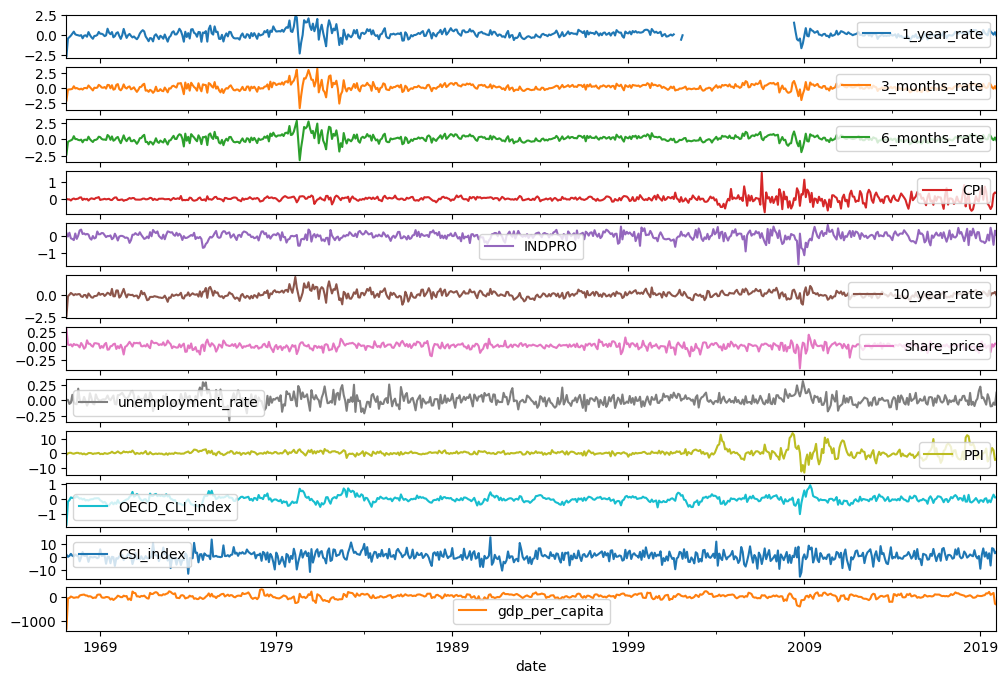

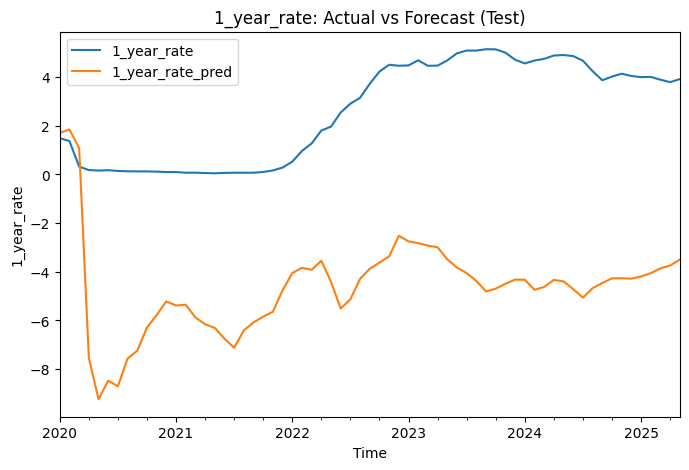

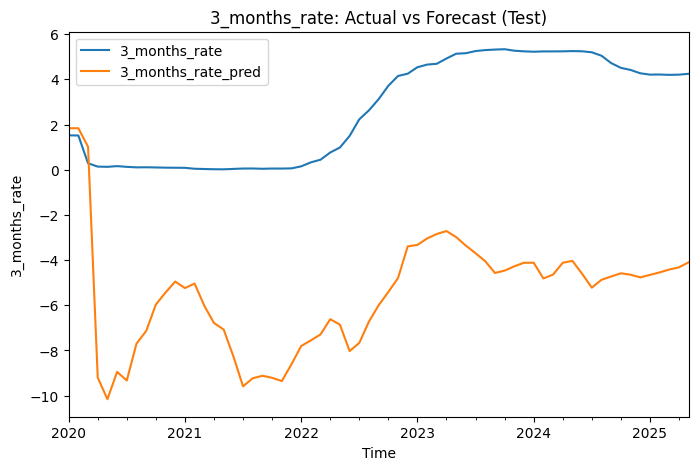

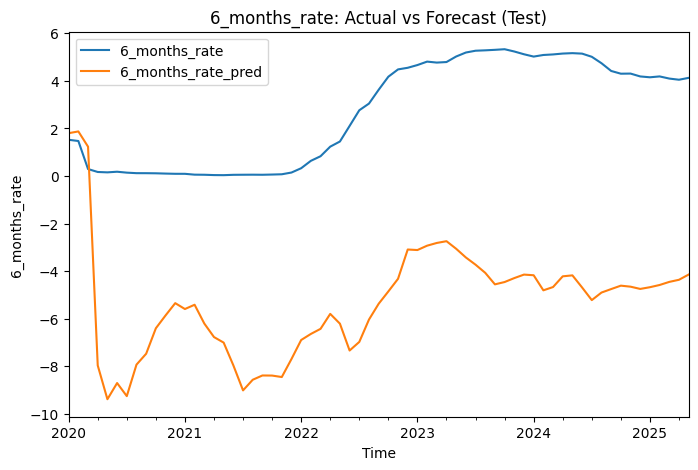

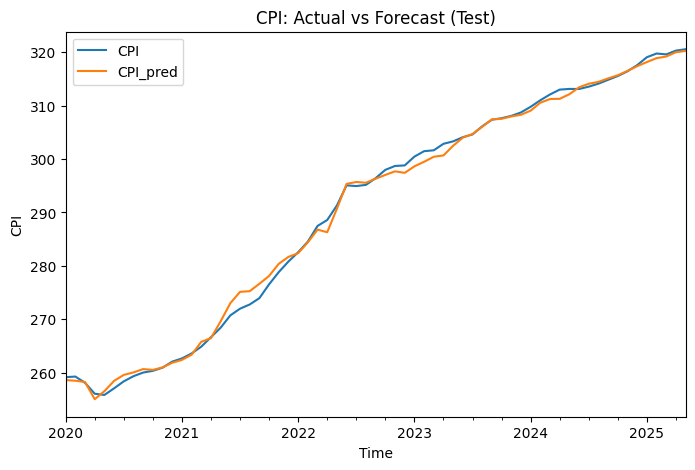

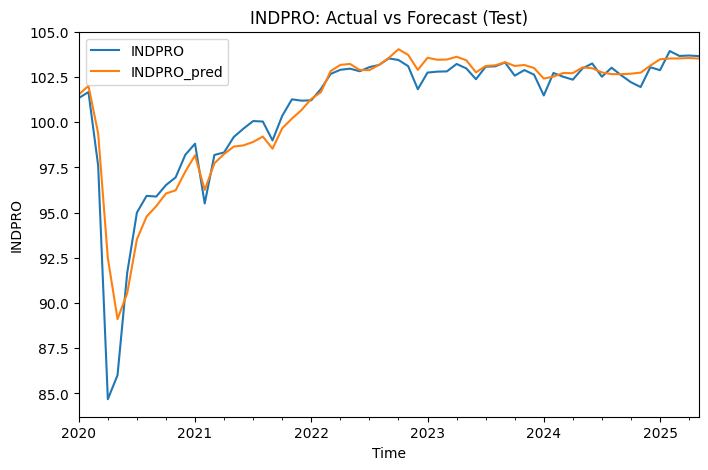

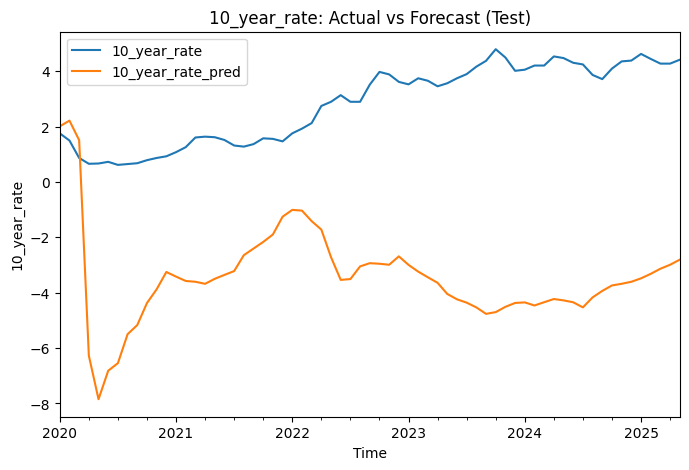

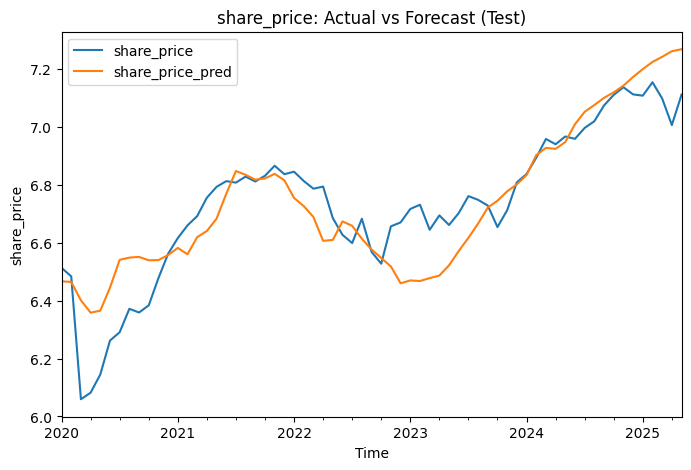

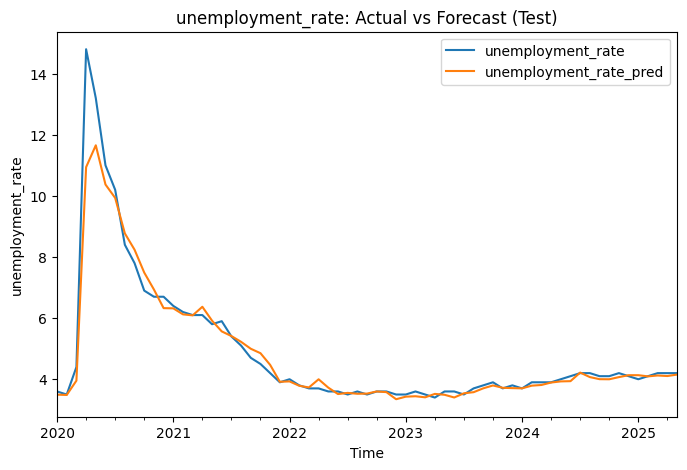

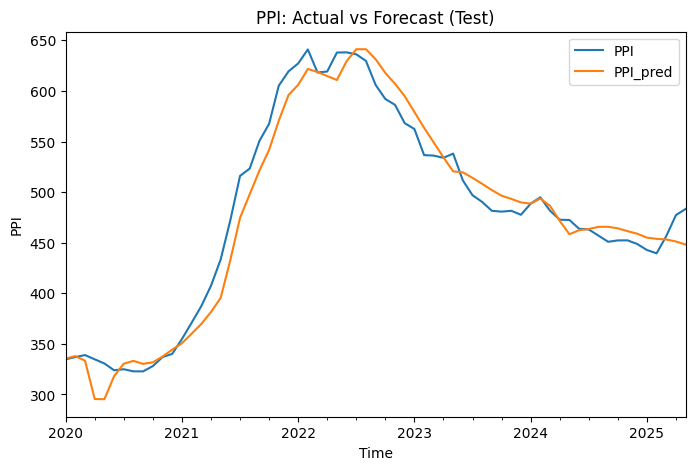

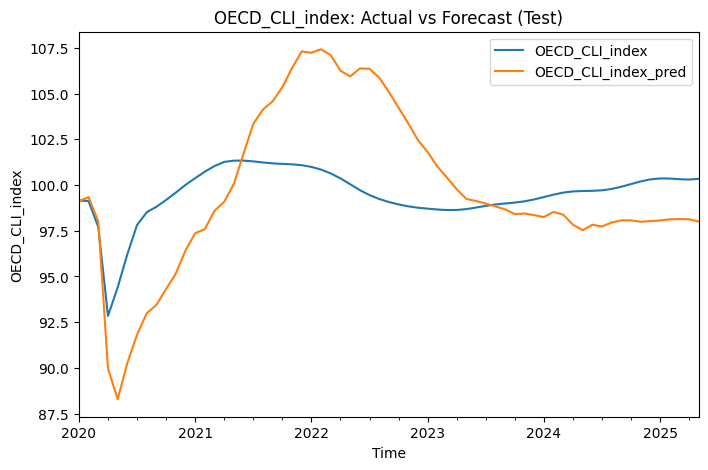

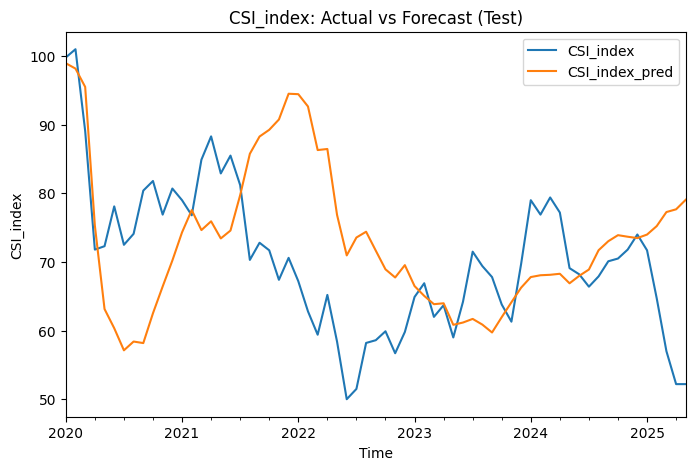

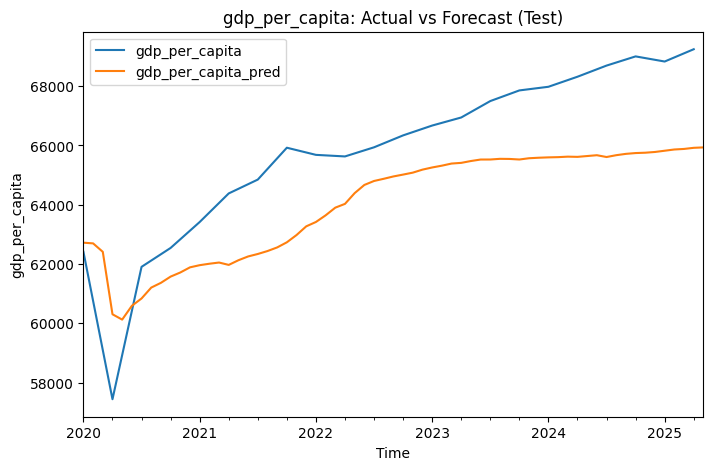

In [13]:
results = run_multivariate_pipeline(dim_reduced_df)
preds = results['predictions_vs_actuals']   # contains actuals + *_pred columns for all 12 series
metrics = results['metrics']                # MAE/RMSE/MAPE per series
print(results['model_summary'])             # Optional: model summary

for col in preds.columns:
    if not col.endswith("_pred"):  # Only pick actual series
        series = col
        if f"{series}_pred" in preds.columns:  # Ensure prediction exists
            preds[[series, f"{series}_pred"]].plot(
                title=f"{series}: Actual vs Forecast (Test)",
                figsize=(8, 5)
            )
            plt.xlabel("Time")
            plt.ylabel(series)
            plt.show()